In [34]:
import copy
import itertools
import pickle
from pathlib import Path

import glob2
import datetime

import numpy as np
from scipy.signal import find_peaks
from tqdm.notebook import tqdm
import tensorflow as tf
from skimage.transform import resize
from matplotlib import pyplot as plt

from src.detection.associator_segmenter import best_matchups_combinatory, locate, find_candidates
from src.detection.clustering import get_valid, get_clusters, get_delta
from utils.data_reading.catalogs.ISC import ISC_file
from utils.data_reading.sound_data.sound_file_manager import NpyFilesManager
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.bathymetry.bathymetry_grid import BathymetryGrid
from utils.physics.sound.sound_model import HomogeneousSoundModel
from utils.physics.sound.sound_velocity_grid import MonthlySoundVelocityGridOptimized
from utils.transformations.features_extractor import STFTFeaturesExtractor

In [37]:
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"

year = 2020
isc_file = f"/home/plerolland/Bureau/catalogs/ISC/eqk_isc_{year}.txt"
detections_file = f"../../data/detections/{year}/detections.npy"  # obtained from associator_preprocess

sound_model_h = HomogeneousSoundModel()
sound_model_g = MonthlySoundVelocityGridOptimized([f"../../data/sound_model/min-velocities_month-{i:02d}.nc" for i in range(1,13)], interpolate=True)
if 'bathy_model' not in locals():
    bathy_model = BathymetryGrid.create_from_NetCDF("../../data/geo/GEBCO_2023_sub_ice_topo.nc", lat_bounds=[-75, 35], lon_bounds=[-20, 180])

stations_c = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
stations_c = stations_c.starts_before(datetime.datetime(year+1, 1, 1))
stations_c = stations_c.ends_after(datetime.datetime(year, 1, 1))
stft_computer = STFTFeaturesExtractor(None, vmin=60, vmax=140, f_min=5, f_max=60)

MIN_P = 0.2
MIN_P_MATES = 0.2
NB = 3
TOLERANCE = datetime.timedelta(seconds=20)
TIME_DELTA_SEARCH = datetime.timedelta(seconds=5*86400)

TIME_RES = 0.5 # duration, in s, of a sample in the associator results
HALF_FOCUS_SIZE = 16  # window to compare for associator -> keep what was used for training
MAX_SHIFT = 128  # max allowed shift resulting from associator

# output
RES_FILE = f"../../data/detections/{year}/matchups_clusters_loc_adjusted_experiment.csv"

### Detections computation

In [39]:
detections = np.load(detections_file, allow_pickle=True).item()
embedding_managers = {s : NpyFilesManager(f"../../data/detections/{year}/embedding_{year}_{s.name}-{s.date_start.year}", fill_empty_with_zeroes=False) for s in detections.keys()}

# merge all detections and sort them by date
stations = list(detections.keys())
merged_detections = []
for s, dets in detections.items():
    for det in dets:
        merged_detections.append((det[0], det[1], s))
merged_detections = np.array(merged_detections, dtype=np.object_)
merged_detections = merged_detections[np.argsort(merged_detections[:,0])]

merged_detections_kept = merged_detections[merged_detections[:,1]>MIN_P]
print(f"{len(merged_detections_kept)} detections kept out of {len(merged_detections)}")

918146 detections kept out of 3082470


### ISC loading

In [41]:
isc = ISC_file(isc_file)

# filter isc events to keep only events from ridges
to_del = set()
for ID, event in isc.items.items():
    if bathy_model.get_nearest_values(event.get_pos()) > 0:
        to_del.add(ID)
    lat, lon = tuple(isc[ID].get_pos())
    if (lat>-5 and lon > 115) or (lat>-30 and lon > 130) or (lat>-50 and lon>150) or (lat>-20 and lon>85):
        to_del.add(ID)
for ID in to_del:
    del isc.items[ID]
print(f"{len(to_del)} terrestrial events removed from catalog ({len(isc.items)} remain)")

IDs = list(isc.items.keys())

# ISC clustering
allowed_delta = 30
delta = get_delta(isc, allowed_delta)
valid = get_valid(allowed_delta, delta, IDs)
clusters = get_clusters(IDs, valid)

res = ""
for id, cluster in clusters.items():
    for ID in cluster:
        res += f"{isc[ID].get_pos()[0]},{isc[ID].get_pos()[1]},{id}\n"
with open("res.csv", "w") as f:
    f.write(res)
    
date_min = [np.min([isc[ID].date for ID in cluster]) for cluster in clusters.values()]
clusters = list(clusters.values())
clusters = [clusters[i] for i in np.argsort(date_min)]

15355 terrestrial events removed from catalog (1055 remain)


### Association

In [ ]:
def associate_cluster(cluster, stations_c, isc, merged_detections_kept, embedding_managers, res_file, nb=3, date_seen_delta=datetime.timedelta(seconds=20)):
    centroid = np.mean([isc[ID].get_pos() for ID in cluster], axis=0)
    dates = [isc[ID].date for ID in cluster]
    date_min, date_max = np.min(dates)-datetime.timedelta(seconds=86400*1), np.max(dates)+datetime.timedelta(seconds=86400*1)
    date_mid = date_min + (date_max - date_min) / 2

    stations_crisis = stations_c.ends_after(date_min).starts_before(date_max)
    bathy = {s: bathy_model.get_along_path_nearest(centroid, s.get_pos())[0] for s in stations_crisis}
    stations_crisis = [s for s in bathy.keys() if np.max(bathy[s])<400]
    expected = {s: sound_model_g.get_sound_travel_time(centroid, s.get_pos(), date=date_mid) for s in stations_crisis}
    # d_h[s1][s2] = given a detection on s1, time to wait before getting it on s2 (can be negative)
    d_h = {s1: {s2: datetime.timedelta(seconds=expected[s2] - expected[s1]) for s2 in stations_crisis} for s1 in
           stations_crisis}
    associate_area(d_h, merged_detections_kept, embedding_managers, date_min, date_max, res_file, nb, date_seen_delta, initial_pos_loc=centroid, ref_name=cluster[0])

def associate_area(d_h, merged_detections_kept, embedding_managers, date_min, date_max, res_file, nb=3, date_seen_delta=datetime.timedelta(seconds=20),
              seen_dates=None, initial_pos_loc=None, ref_name=None):
    if seen_dates is None:
        seen_dates = []
    if len(d_h) <= nb:
        return
    idx_min = np.searchsorted(merged_detections_kept[:, 0], date_min, side='right')
    idx_max = np.searchsorted(merged_detections_kept[:, 0], date_max, side='left')
    if len(d_h) == 0:
        return
    max_d = np.max([list(d.values()) for d in d_h.values()])
    for idx in tqdm(range(idx_min, idx_max), position=0, leave=False):
        detection = merged_detections_kept[idx]
        
        # update seen dates to keep only recent
        to_del = list()
        for i in range(len(seen_dates)):
            if seen_dates[i] < detection[0] - max_d:
                to_del.append(i)
        seen_dates = list(np.delete(seen_dates, to_del, axis=0))
        if len(seen_dates) > 0 and np.min(detection[0]-np.array(seen_dates)) < date_seen_delta:
            continue
            
        associate(detection, d_h, embedding_managers, res_file, nb, date_seen_delta, seen_dates, initial_pos_loc=initial_pos_loc, ref_name=ref_name, ref_date=date_min)
        
        
def associate(detection, d_h, embedding_managers, res_file, nb=3, date_seen_delta=datetime.timedelta(seconds=20), seen_dates=None, initial_pos_loc=None, ref_name=None, ref_date=None):
    if seen_dates is None:
        seen_dates = []
    candidates = find_candidates(detection, d_h, TOLERANCE, embedding_managers, min_p=MIN_P_MATES)
    d1, s1 = detection[0], detection[-1]
    
    # remove already used dates
    s2_to_del = list()
    for s2 in candidates.keys():
        to_del = list()
        for j, candidate in enumerate(candidates[s2]):
            if len(seen_dates) > 0 and np.min(candidate[0]-np.array(seen_dates)) < date_seen_delta:
                to_del.append(j)
        candidates[s2] = np.delete(candidates[s2], to_del, axis=0)
        if len(candidates[s2]) == 0:
            s2_to_del.append(s2)
    for s2 in s2_to_del:
        del candidates[s2]
        
    # check we have enough stations
    if len(candidates) < nb:
        return
        
    # get best matchups
    scores = {s: c for s, c in candidates.items()}
    best_matchups = best_matchups_combinatory(scores, nb, d_h, TOLERANCE)
    if len(best_matchups) == 0:
        return
    matchup_scores = []
    for matchup in best_matchups:
        matchup = [[d1, 0, s1]] + [[d2, j2, s2] for (d2, j2, s2) in matchup]
        loc_worked, loc_res = locate(matchup, sound_model_h, 10, initial_pos=initial_pos_loc)
        matchup_scores.append(loc_res.cost if loc_res else np.inf)
    best_matchup = best_matchups[np.argmin(matchup_scores)]

    matchup = [[d1, 0, s1]] + [[d2, j2, s2] for (d2, j2, s2) in best_matchup]
    loc_worked, loc_res = locate(matchup, sound_model_h, 10, initial_pos=initial_pos_loc)

    # if it didn't work because loc was not close enough, we try deleting a station
    if not loc_worked and type(loc_res) != list and len(matchup) > nb + 1:
        to_del = np.argmax(loc_res.fun)  # index of maximum residual
        matchup = matchup[:to_del] + matchup[to_del+1:]
        loc_worked, loc_res = locate(matchup, sound_model_h, 10, initial_pos=initial_pos_loc)

    # in case it worked, go further and try to locate
    if loc_worked:
        loc_worked, loc_res = locate(matchup, sound_model_g, 10, initial_pos=initial_pos_loc)
        if loc_worked:
            # add other stations
            seen_stations = set([c[-1] for c in matchup])
            for s, c in candidates.items():
                if s in seen_stations:
                    continue
                c = np.array(c)
                possible = [True] * len(c)
                for (d2, _, s2) in matchup:
                    possible = np.logical_and(possible, d2 + d_h[s][s2] - TOLERANCE < c[:,0])
                    possible = np.logical_and(possible, c[:,0] < d2 + d_h[s2][s] + TOLERANCE)
                if np.count_nonzero(possible) == 0:
                    continue
                c = c[possible]
                for chosen in c[np.argsort(c[:,1])]:
                    new_matchup = matchup + [chosen]
                    loc_worked_new, loc_res_new = locate(new_matchup, sound_model_g, 10, initial_pos=initial_pos_loc)
                    if loc_worked_new:
                        seen_stations.add(s)
                        loc_worked, loc_res = loc_worked_new, loc_res_new
                        matchup = new_matchup
                        break

            det_times = [c[0] for c in matchup]
            date_event = np.min(det_times) + datetime.timedelta(seconds=loc_res.x[0])
            try:
                J = loc_res.jac
                cov = np.linalg.inv(J.T.dot(J))
                var = np.sqrt(np.diagonal(cov))
            except:
                var = [-1, -1, -1]

            # note: we register one ISC event from the cluster
            to_write = (f'{date_event.strftime("%Y%m%d_%H%M%S")},{loc_res.x[1]:.4f},{loc_res.x[2]:.4f},'
                        f'{var[0]:.4f},{var[1]:.4f},{var[2]:.4f},{ref_name},{(date_event-ref_date).total_seconds():.1f}')
            for d, _, s in matchup:
                to_write += f',{s.name}-{s.date_start.year},{d.strftime("%Y%m%d_%H%M%S")}'
                seen_dates.append(d)
            with open(res_file, "a") as f:
                f.write(to_write + "\n")


cluster = clusters[647]
print(isc[cluster[0]])
#associate_cluster(cluster, stations_c, isc)
#with open(RES_FILE, "r") as f:
#    lines = [[l.strip() for l in line.split(",")] for line in f.readlines()]
IDS = []
#IDS = set([int(id) for id in np.array(lines)[:,6]]) if len(lines)>0 else []
#associate_cluster(cluster, stations_c, isc, merged_detections_kept, embedding_managers, RES_FILE, NB)

for cluster in tqdm(clusters):
    seen = False
    for id in cluster:
        if id in IDS:
            seen = True
    if seen:
        continue
    associate_cluster(cluster, stations_c, isc, merged_detections_kept, embedding_managers, RES_FILE, NB)

ISC event 619554305 - (-37.4707,51.0389,-16.0) at 2020-11-09 07:20:10.220000


  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/5084 [00:00<?, ?it/s]

### Experiment

STATIONS:
(257,)
[datetime.timedelta(days=-1, seconds=86366), datetime.timedelta(days=-1, seconds=86399), datetime.timedelta(seconds=26), datetime.timedelta(days=-1, seconds=86356)] [0.1212287  0.19601652 0.26301765 0.37717476]


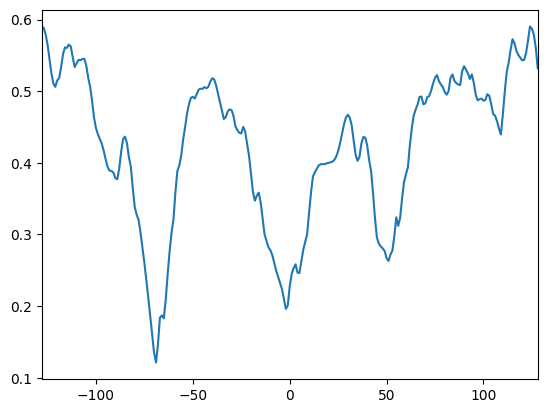

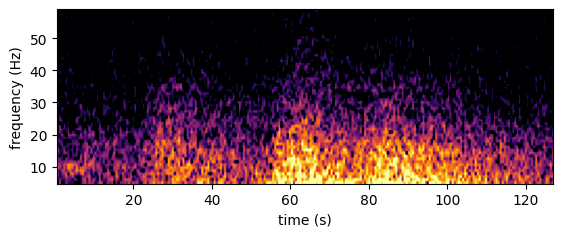

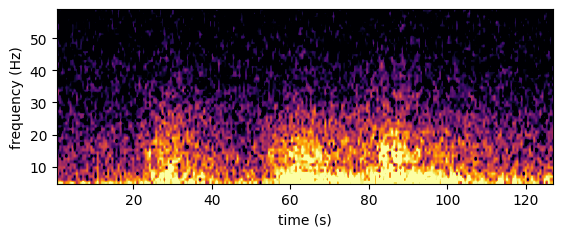

In [25]:
# testing code
if True:
    s1, s2 = stations_c.by_names("NEAMS")[0], stations_c.by_names("WKER2")[0]
    print("STATIONS:")
    m1, m2 = embedding_managers[s1], embedding_managers[s2]
    # 1.197507344E+09 2012 347005543.779   99.72
    # 1.197507790E+09 2012 3470103 9.889  116.64
    d1, d2 = datetime.datetime(2012, 12, 12, 3, 57, 40), datetime.datetime(2012, 12, 12, 4, 14, 0)
    diff = get_embedder_similarities(d1, m1, d2, m2, min_p=None)
    print(diff.shape)
    plt.plot(np.arange(len(diff))-len(diff)//2, diff)
    plt.xlim(-MAX_SHIFT, MAX_SHIFT)
    plt.figure()
    
    delta = datetime.timedelta(seconds=MAX_SHIFT//2)
    stft_computer.manager = s1.get_manager()
    stft_computer.show_features(d1-delta, d1+delta)
    
    plt.figure()
    stft_computer.manager = s2.get_manager()
    stft_computer.show_features(d2-delta, d2+delta)
    
    p, h = get_embedder_similarities(d1, m1, d2, m2)
    print(p,h)
    
# TODO make tolerance relative to distance (like 5%), updatable max bound of max-date when new dets are found, sort peaks by station distance

In [ ]:
test = False
if test:
    centroid = np.mean([isc[ID].get_pos() for ID in cluster], axis=0)
    dates = [isc[ID].date for ID in cluster]
    date_min, date_max = np.min(dates), np.max(dates)+datetime.timedelta(seconds=86400)
    date_mid = date_min + (date_max - date_min) / 2
    
    expected = {s: sound_model_g.get_sound_travel_time(centroid, s.get_pos(), date=date_mid) for s in stations}
    # d_h[s1][s2] = given a detection on s1, time to wait before getting it on s2 (can be negative)
    stations_crisis = stations_c.ends_after(date_min).starts_before(date_max)
    bathy = {s: bathy_model.get_along_path_nearest(centroid, s.get_pos())[0] for s in stations_crisis}
    stations_crisis = [s for s in bathy.keys() if np.max(bathy[s])<400]
    d_h = {s1: {s2: datetime.timedelta(seconds=expected[s2] - expected[s1]) for s2 in stations_crisis} for s1 in
           stations_crisis}
    s = stations_c.by_names("WKER2")[0]
    d = (datetime.datetime(2012,12,12,4,11,12),s)
    candidates = find_candidates(d, d_h, tolerance=TOLERANCE,
                                         min_p=MIN_P_MATES)
    scores = {s: c for s, c in candidates.items()}
    best_m = best_matchups_combinatory(scores, NB, d_h, TOLERANCE)
    print(best_m)
    best_m = best_m[0]
    matchup = [[d[0], 0, s]] + [[d, j, s] for (d, j, s) in best_m]
    for c in matchup:
        print(c[0], c[1], c[2].name)
    
    
    # LOCATION TEST
    det_times = [c[0] for c in matchup]
    det_pos = [c[-1].get_pos() for c in matchup]
    r = sound_model_g.localize_common_source(det_pos, det_times, initial_pos=list(centroid))
    print(r)
    
    diff = get_embedder_similarities(matchup[1][0], embedding_managers[matchup[1][2]], d[0], embedding_managers[s], min_p=None)
    print(diff.shape)
    plt.plot(np.arange(len(diff))-len(diff)//2, diff)
    plt.xlim(-MAX_SHIFT, MAX_SHIFT)